This will be a record of my additions to graham's analysis on his grass endophyte paper. 

[Python setup](#pySetup)  
[Rebuilding biome tables](#deseq)  
- [Spatial dataframe](#spatDF)  
- [Diversity dataframe](#divDF)

[Dan's task #1: South-to-North diversity gradient](#NSDiv)  
[Dan's task #2: checking polynomial surfaces](#polySurf)  
[Dan's task #3: find out why French Flat is so weird](#FF)
  - [French Flat indicator species](#FFind)
  - [The curious case of the unknown <i>Colletotrichum </i>](#colleto)  
  - [Are microbiomes of hosts converging at French Flat?](#ffDiff)

<a id="pySetup"></a>  


## Python setup


A lot of the work below is in R, but when I can I prefer to wrestle my data in python, with pandas, numpy, etc. Here is the import block for packages we'll use:

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from Bio import SeqIO
from Bio import Phylo
from Bio import Entrez
import re

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


<a id="deseq"></a>   





## Rebuilding biom tables 

We'll need a couple different biom tables: with raw abundances, variance stabilized, with/out controls, etc. etc. We'll also want them out as csvs so we can move between R and python with ease. 

In [5]:
## grahams basic biom table is here. He did a great job assigning taxonomy, etc. 
library(phyloseq)
library("DESeq2")
library("indicspecies")
library("vegan")

Loading required package: permute


Attaching package: ‘indicspecies’


The following object is masked from ‘package:SummarizedExperiment’:

    coverage


The following object is masked from ‘package:GenomicRanges’:

    coverage


The following object is masked from ‘package:IRanges’:

    coverage


Loading required package: lattice

This is vegan 2.5-7



In [5]:
biom97 <- import_biom('~/Documents/analyses/grahamGrass/grass-endophyte-community/grass_97_wmeta.biom')

biom97_noCon = subset_samples(biom97, site != 'Control')

In [2]:
#write.csv(sample_data(biom97), file='grahamSample.csv')

As our [first task below](#NSDiv), we're doing an analysis of biodiversity as a function of latitude. To make comparisons of diversity among samples with very different read numbers, we'll need to rarify back to common numbers of reads. For the moment, we'll try the lowest number that let's us include all samples that are not controls (~7000 reads), and go up from there to 20,000 reads:

In [5]:
# get rid of controls
biom97_noCon = subset_samples(biom97, site != 'Control')

## split by host, with a few different read depths:
sampsizes = c(7000, 18000, 30000, 40000)
hosts = c("F. roemeri", "D. californica")

for (j in hosts){
    biom97.i = subset_samples(biom97_noCon, host == j)
    for (i in sampsizes){
        filename = paste(j,"diversity",i,".csv", sep='')
        biom97_rar.i = rarefy_even_depth(biom97.i, sample.size = i, rngseed = 1)
        aa <- estimate_richness(biom97_rar.i, measures=c('Simpson', 'Observed'))
        write.csv(aa, file=filename)
    }
}


`set.seed(1)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1); .Random.seed` for the full vector

...

1718OTUs were removed because they are no longer 
present in any sample after random subsampling


...

`set.seed(1)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1); .Random.seed` for the full vector

...

5 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


10grass11grass14grass15grass16grass

...

1371OTUs were removed because they are no longer 
present in any sample after random subsampling


...

`set.seed(1)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1); .Random.seed` for the full vector

...

12 samples removedbecause they contained fewer reads than `sample.siz

We're also going to need a variance stabilized version to make other ecological comparisons. While I have reservations about quantitative modeling with even variance-stabilized abundances, I gather it is still one of the better compromises available: it is probably better than simple rarifaction and probably a lot better than doing nothing.

In [6]:
aa <- otu_table(biom97_noCon)@.Data
bb <- varianceStabilizingTransformation(aa)
bb[bb < 0] <- 0
biom97vs <- biom97_noCon
otu_table(biom97vs) <- otu_table(bb, taxa_are_rows = TRUE)
biom97vs = filter_taxa(biom97vs, function(x) sum(x) > 0.1, T)

converting counts to integer mode



In the above steps, we create a variance-stabilized matrix of read abundances, and then drop the values at or below zero. I'm follwing the notes of my colleague Roo Vandegrift for the removal of the negative values. This is not quite a perfect solution, as the zero point is a bit arbritrary, and discarding all points below zero discards "real" observations. After poking around the transformed data, it seems that the negative values up to zero in the new, variance stabilized matrix represent species-site observation totals of 4 or less on the original OTU table. So discarding all negative values from the variance stabilized matrix is equivalent to dropping all site-observations of 4 reads or less. I'm fine with this, given my reservations about index bleed, etc, in Illumina data, especially from the era of this library, and my knowledge of the particulars of this illumina run (see our forever-pre-print [here](https://doi.org/10.1101/184960)).

In [8]:
biom97
biom97vs


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3880 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 51 sample variables ]
tax_table()   Taxonomy Table:    [ 3880 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3670 taxa and 155 samples ]
sample_data() Sample Data:       [ 155 samples by 51 sample variables ]
tax_table()   Taxonomy Table:    [ 3670 taxa by 7 taxonomic ranks ]

<a id='spatDF'></a>
### Spatial dataframe

To get our by-site geographic information:

In [15]:
grahamSample = pd.read_csv('grahamSample.csv', index_col=0)
grahamSample.head()

,percent_sand,latitude,percent_C,WINTER.PRECIPITATION,region,SPRING.MAX.TEMPERATURE,ANNUAL.MIN.TEMPERATURE,total_N,stems,NO3,...,ANNUAL.PRECIPITATION,soil_pH,stems_browsed,C_to_N,elevation,percent_clay,seeds_produced,ANNUAL.MEAN.TEMPERATURE,SUMMER.DEWPOINT.TEMPERATURE,density
5grass,51.42,42.1,2.17,262.31,SOR,20.54,3.95,20.36,19.0,18.72,...,1599.87,7.51,0.0,0.02,448.0,30.2,1143.61,11.94,7.12,18.76
6grass,51.42,42.1,2.17,262.31,SOR,20.54,3.95,20.36,23.0,18.72,...,1599.87,7.51,0.0,0.02,448.0,30.2,1597.35,11.94,7.12,18.76
7grass,51.42,42.1,2.17,262.31,SOR,20.54,3.95,20.36,47.0,18.72,...,1599.87,7.51,3.0,0.02,448.0,30.2,2648.36,11.94,7.12,18.76
8grass,51.42,42.1,2.17,262.31,SOR,20.54,3.95,20.36,38.0,18.72,...,1599.87,7.51,0.0,0.02,448.0,30.2,1583.46,11.94,7.12,18.76
9grass,51.42,42.1,2.17,262.31,SOR,20.54,3.95,20.36,35.0,18.72,...,1599.87,7.51,0.0,0.02,448.0,30.2,1458.45,11.94,7.12,18.76


Seems like we have two latitudes for Hazel Dell:

In [16]:
grs = grahamSample.groupby('site')
print(grs.get_group('Hazel_Dell').latitude.unique())
print(grs.get_group('Hazel_Dell').longitude.unique())

[44.03 44.02]
[-123.22]


In [17]:
print(f'Total sites at latitude 44.03 = {sum(grahamSample.latitude == 44.03)}')
print(f'Total sites at latitude 44.02 = {sum(grahamSample.latitude == 44.02)}')

Total sites at latitude 44.03 = 12
Total sites at latitude 44.02 = 12


For the moment, we'll assume that the Hazel Dell sites all have the same latitude, that this is some sort of rounding error. We'll keep the more southern location, until someone tells us otherwise:

In [18]:
hd4403 = grahamSample.latitude == 44.03
grahamSample.latitude[hd4403] = 44.02

<ipython-input-18-f263d2f1635e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grahamSample.latitude[hd4403] = 44.02


I hate the slicing issue, always pops up. To make sure:

In [19]:
print(f'Total sites now at latitude 44.03 = {sum(grahamSample.latitude == 44.03)}')
print(f'Total sites now at latitude 44.02 = {sum(grahamSample.latitude == 44.02)}')

Total sites now at latitude 44.03 = 0
Total sites now at latitude 44.02 = 24


Looks like it worked. Subset to just the columns of interest:

In [21]:
aa = grahamSample[['site','latitude','longitude']]
bb = aa.reset_index(drop=True)
dd = bb.drop_duplicates()
dd.set_index('site', inplace=True)
ee = dd.drop('Control')
print(ee)

             latitude  longitude
site                            
French_flat     42.10    -123.63
Upper_Table     42.47    -122.88
Hazel_Dell      44.02    -123.22
Horse_Rock      44.30    -122.88
Upper_Weir      46.91    -122.71
Whidbey         48.21    -122.62
Roxy_Ann        42.35    -122.79
Whetstone       42.42    -122.91
Lower_Table     42.47    -122.95


Nice, but we want UTMs, and a proper geopandas df:

In [25]:
grahamSites = (gpd.GeoDataFrame(
    ee, geometry=gpd.points_from_xy(ee.longitude, ee.latitude))
    .drop(['latitude','longitude'], axis=1)
)

grahamSites.set_crs('EPSG:4326', inplace=True)
## reproject to UTM zone 10, which is EPSG:26710
grahamSites.to_crs('EPSG:26710', inplace=True)
grahamSites

,geometry
site,
French_flat,POINT (448002.580 4660874.730)
Upper_Table,POINT (509959.448 4701771.456)
Hazel_Dell,POINT (482462.948 4873918.789)
Horse_Rock,POINT (509667.410 4905002.198)
Upper_Weir,POINT (522179.104 5195005.240)
Whidbey,POINT (528326.591 5339512.618)
Roxy_Ann,POINT (517390.804 4688461.394)
Whetstone,POINT (507499.198 4696216.553)
Lower_Table,POINT (504205.130 4701765.701)


In [ ]:
#grahamSites.to_csv('grahamSiteCoords.csv')
## not a perfect export, have to modify with vim to get a good csv
## but works

## and maybe save us some work later:
#grahamSites.to_pickle('grahamSiteCoords.p')

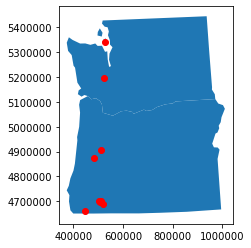

In [27]:
## check it on some maps. Here are some publicly available geojsons:
fig, ax = plt.subplots()
oregon = gpd.read_file('OR.geo.json')
oregon.to_crs('EPSG:26710', inplace=True)
washington = gpd.read_file('WA.geo.json')
washington.to_crs('EPSG:26710', inplace=True)
oregon.plot(ax=ax)
washington.plot(ax=ax)
grahamSites.plot(ax=ax, color='red')



Looks right...

<a id='divDF'></a>
### Diversity dataframe

Here is a function for cleaning up the csv's we got from the `phyloseq` `estimate_richness()` function:

In [2]:
def siteRichnessGPD(gpdDiv):
    ## convert diversity results
    aa = pd.read_csv(gpdDiv)
    aa.columns=['sampleName','Observed','Simpson']
    aa['sampleName'] = aa.sampleName.str.replace('X', '')
    aa.set_index('sampleName', inplace=True)
    ## convert sample data, just to get the site name and host
    bb = pd.read_csv('grahamSample.csv', index_col=0)
    bb = bb[['host','site', 'samplename']]
    ## bring our site geo info again:
    grahamSites = pd.read_pickle('grahamSiteCoords.p')
    ## attach name and host onto the diversity data
    dd = bb.merge(aa, left_index=True, right_index=True)
    ## make a gpdf
    grahamDivGPD = grahamSites.merge(dd, right_on='site', left_index=True)
    del(aa,bb,dd)
    aa = grahamDivGPD.groupby('site').mean()
    bb = grahamDivGPD.groupby('site').std()
    cc = aa.merge(bb, left_index=True, right_index=True)
    cc.columns = ['richness', 'simpson', 'richnessSD', 'simpsonSD']
    siteRichness = grahamSites.merge(cc, left_index=True, right_index=True)
    return(siteRichness)

In [3]:
def plotDiv(gpdRich, tit='', ax=None):
    if ax is not None: ax=ax
    if ax is None: fig, ax = plt.subplots()
    ax.errorbar(x=gpdRich['geometry'].y,
                y=gpdRich['richness'],
                yerr=gpdRich['richnessSD'],
                fmt='o',)
    ## ols line
    X = gpdRich['geometry'].y.to_numpy().reshape(-1,1)
    Y = gpdRich['richness'].to_numpy().reshape(-1,1)
    ax.plot( X, LinearRegression().fit(X, Y).predict(X),
            c='k', linewidth=2, #linestyle= "dotted",
            label='OLS linear regression model'
           )
    ## site labels:
    labs = gpdRich.index.to_series()
    xy = zip(gpdRich['geometry'].y, gpdRich['richness'])
    for i,j in enumerate(xy):
        ax.annotate(labs[i], xy=j)
    ## include linear regression results
    corStats = stats.linregress( gpdRich['geometry'].y, gpdRich['richness'])
    corString = (f'Pearson\'s r = {round(corStats[2],3)}, p = {round(corStats[3],3)}')
    top = ax.get_ylim()[1]
    right = ax.get_xlim()[1]
    ax.text(right, top, corString,
            horizontalalignment='right',
            verticalalignment='top')
    ax.set_title(tit)


So we can use these to look at our species richness trends...

## Dan's task #1: South-to-North diversity gradient
<a id="NSDiv"></a>

There are some indications of a trend of increasing diversity of endophytes with latitude, especially with <i>Danthonia</i>

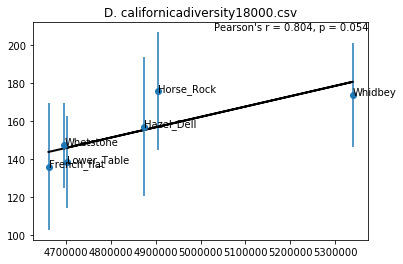

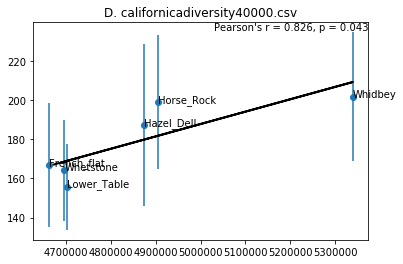

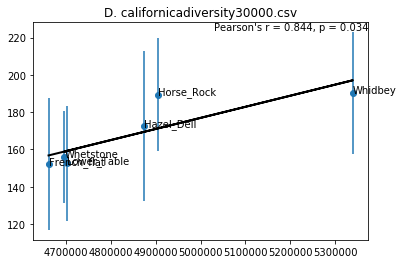

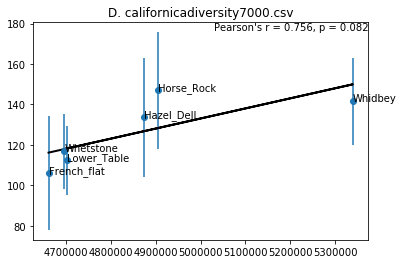

In [5]:
## look at the danthonia graphs:
gpdDiv_filenames = [ i for i in os.listdir() if "californicadiversity" in i ]

for i,j in enumerate(gpdDiv_filenames):
    gpdRich = siteRichnessGPD(j)
    plotDiv(gpdRich, tit=j)


The correlation is weaker and not statistically significant in <i>Festuca</i>.

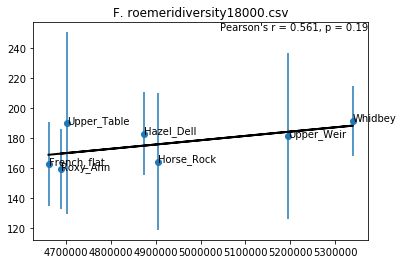

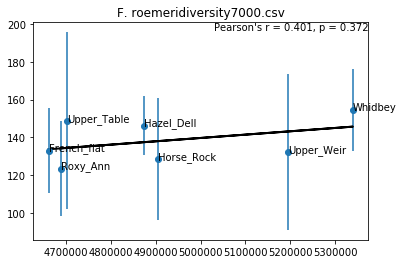

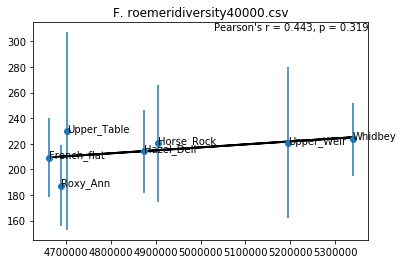

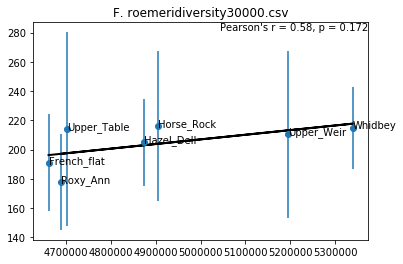

In [6]:
## look at the danthonia graphs:
gpdDiv_filenames = [ i for i in os.listdir() if "roemeridiversity" in i ]

for i,j in enumerate(gpdDiv_filenames):
    gpdRich = siteRichnessGPD(j)
    plotDiv(gpdRich, tit=j)


## Dan's task #2: checking polynomial surfaces
<a id="polySurf"></a>

Graham's MEM analysis showed a few broad trends. We thought we should also see if any spatial trends could be modeled as polynomial trend surface models. Given the shape of the sampling scheme, we'll treat this scheme as a large geographical transect, in a north-south axis. There is some east/west variation in the sites, of course, but it is likely that this range of longitudes isn't useful for us, it is just too small. 

Start out in R, to get some data out of phyloseq objects:

In [1]:
library('ade4')
library('vegan')
library('phyloseq')

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



In [2]:
biom97 <- import_biom('~/Documents/analyses/grahamGrass/grass-endophyte-community/grass_97_wmeta.biom')
## get rid of controls
biom97_noCon = subset_samples(biom97, site != 'Control')
## split by host
danthBiom = subset_samples(biom97_noCon, host == 'D. californica' )
festuBiom = subset_samples(biom97_noCon, host == 'F. roemeri')
## get OTU tables
danthOTU = otu_table(danthBiom)
festuOTU = otu_table(festuBiom)


Use pandas in python to reshape, aggregate data. In general, we are going to combine the microbiome data of all plants of a given host species (<i>Danthonia</i> or <i>Festuca</i>) for each site. There were usually 12 plants sampled at each site, and we will pool these for a representative of the microbiome for each plant species at a site. 

In [1]:
import numpy as np
import pandas as pd

sampleData = pd.read_csv("grahamsSampleData.csv", index_col=0)


In [2]:
## danthonia data
aa = pd.read_csv('danthOTU.csv')
danthOTU = aa.T
aa = danthOTU.merge(sampleData.site, left_index=True, right_index=True)
danthSiteOTUsums = aa.groupby('site').sum()
danthSiteOTUsums.to_csv('danthSiteOTUsums.csv')


In [3]:
## festuca data
aa = pd.read_csv('festOTU.csv')
festOTU = aa.T
aa = festOTU.merge(sampleData.site, left_index=True, right_index=True)
festSiteOTUsums = aa.groupby('site').sum()
festSiteOTUsums.to_csv('festSiteOTUsums.csv')


We'll do the polynomial analysis in R, mostly because I have a nice tutorial for polynomials using R, in the form of Barcord's [Numerical Ecology with R](https://www.springer.com/gp/book/9783319714035#aboutBook). Generally following this tutorial hopefully makes sure I don't screw this up too badly...

Back in R:

In [1]:
library('ade4')
library('vegan')
library('phyloseq')

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



In [3]:
biom97 <- import_biom('~/Documents/analyses/grahamGrass/grass-endophyte-community/grass_97_wmeta.biom')
## get rid of controls
biom97_noCon = subset_samples(biom97, site != 'Control')

In [2]:
## festuca
festuBiom = subset_samples(biom97_noCon, host == 'F. roemeri')
festuOTU = otu_table(festuBiom)
festSiteOTUsums <- read.csv('festSiteOTUsums.csv', row.names='site')
festOTU.h <- decostand(festSiteOTUsums, "hellinger")
grahamSiteCoords = read.csv('grahamSiteCoords.csv', row.names='site')
festSiteCoords <- grahamSiteCoords[rownames(festSiteOTUsums),]
fest.poly.ortho3 <- poly(as.matrix(festSiteCoords), degree=3)
fest.poly.ortho3.DF <- as.data.frame(fest.poly.ortho3)
colnames(fest.poly.ortho3.DF) <- c("X", "X2", "X3", "Y", "XY", "X2Y", "Y2", "XY2", "Y3")
## danthonia
danthBiom = subset_samples(biom97_noCon, host == 'F. roemeri')
danthOTU = otu_table(danthBiom)
danthSiteOTUsums <- read.csv('danSiteOTUsums.csv', row.names='site')
danthOTU.h <- decostand(danthSiteOTUsums, "hellinger")
danthSiteCoords <- grahamSiteCoords[rownames(danthSiteOTUsums),]
danth.poly.ortho3 <- poly(as.matrix(danthSiteCoords), degree=3)
danth.poly.ortho3.DF <- as.data.frame(danth.poly.ortho3)
colnames(danth.poly.ortho3.DF) <- c("X", "X2", "X3", "Y", "XY", "X2Y", "Y2", "XY2", "Y3")

We only have 7 sites for <i>Festuca</i>, and 6 for <i>Danthonia</i>, so we lack the statistical power to completely follow Borcard's general framework of forward selection of a model with numerous possible polynomials. Also our situation is simpler, in that we have really only one dimension to deal with (north-south). So we'll use the very crude method of checking the first, second, and third degree polynomials of the latitude for each host plant. 

Start with <i>Festuca</i>:

In [11]:
festYmodel <- rda(festOTU.h ~ fest.poly.ortho3.DF$Y)
print(festYmodel)
print(anova.cca(festYmodel))

Call: rda(formula = festOTU.h ~ fest.poly.ortho3.DF$Y)

              Inertia Proportion Rank
Total          0.4592     1.0000     
Constrained    0.1081     0.2353    1
Unconstrained  0.3511     0.7647    5
Inertia is variance 

Eigenvalues for constrained axes:
   RDA1 
0.10806 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4     PC5 
0.17491 0.08248 0.06066 0.01981 0.01328 



Set of permutations < 'minperm'. Generating entire set.



Permutation test for rda under reduced model
Permutation: free
Number of permutations: 5039

Model: rda(formula = festOTU.h ~ fest.poly.ortho3.DF$Y)
         Df Variance      F Pr(>F)
Model     1  0.10806 1.5387  0.181
Residual  5  0.35113              


In [10]:
festY2model <- rda(festOTU.h ~ fest.poly.ortho3.DF$Y2)
print(festY2model)
print(anova.cca(festY2model))

Call: rda(formula = festOTU.h ~ fest.poly.ortho3.DF$Y2)

              Inertia Proportion Rank
Total         0.45919    1.00000     
Constrained   0.07407    0.16131    1
Unconstrained 0.38512    0.83869    5
Inertia is variance 

Eigenvalues for constrained axes:
   RDA1 
0.07407 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4     PC5 
0.16306 0.14067 0.04546 0.02287 0.01306 



Set of permutations < 'minperm'. Generating entire set.



Permutation test for rda under reduced model
Permutation: free
Number of permutations: 5039

Model: rda(formula = festOTU.h ~ fest.poly.ortho3.DF$Y2)
         Df Variance      F Pr(>F)
Model     1  0.07407 0.9617  0.468
Residual  5  0.38512              


In [9]:
festY3model <- rda(festOTU.h ~ fest.poly.ortho3.DF$Y3)
print(festY3model)
print(anova.cca(festY3model))

Call: rda(formula = festOTU.h ~ fest.poly.ortho3.DF$Y3)

              Inertia Proportion Rank
Total          0.4592     1.0000     
Constrained    0.1220     0.2658    1
Unconstrained  0.3372     0.7342    5
Inertia is variance 

Eigenvalues for constrained axes:
   RDA1 
0.12203 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4     PC5 
0.16766 0.08074 0.05306 0.02069 0.01501 



Set of permutations < 'minperm'. Generating entire set.



Permutation test for rda under reduced model
Permutation: free
Number of permutations: 5039

Model: rda(formula = festOTU.h ~ fest.poly.ortho3.DF$Y3)
         Df Variance      F Pr(>F)
Model     1  0.12203 1.8097  0.122
Residual  5  0.33716              


None of the festuca models are well explained by simple y, y<sup>2</sup>, and y<sup>3</sup> trends. 

In [12]:
danthYmodel <- rda(danthOTU.h ~ danth.poly.ortho3.DF$Y)
print(danthYmodel)
print(anova.cca(danthYmodel))

Call: rda(formula = danthOTU.h ~ danth.poly.ortho3.DF$Y)

              Inertia Proportion Rank
Total         0.45430    1.00000     
Constrained   0.08899    0.19589    1
Unconstrained 0.36530    0.80411    4
Inertia is variance 

Eigenvalues for constrained axes:
   RDA1 
0.08899 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4 
0.17431 0.08935 0.06634 0.03530 



'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.



Permutation test for rda under reduced model
Permutation: free
Number of permutations: 719

Model: rda(formula = danthOTU.h ~ danth.poly.ortho3.DF$Y)
         Df Variance      F Pr(>F)
Model     1  0.08899 0.9745 0.5222
Residual  4  0.36530              


In [13]:
danthY2model <- rda(danthOTU.h ~ danth.poly.ortho3.DF$Y2)
print(danthY2model)
print(anova.cca(danthY2model))

Call: rda(formula = danthOTU.h ~ danth.poly.ortho3.DF$Y2)

              Inertia Proportion Rank
Total          0.4543     1.0000     
Constrained    0.1689     0.3718    1
Unconstrained  0.2854     0.6282    4
Inertia is variance 

Eigenvalues for constrained axes:
  RDA1 
0.1689 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4 
0.10841 0.07408 0.06640 0.03652 



'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.



Permutation test for rda under reduced model
Permutation: free
Number of permutations: 719

Model: rda(formula = danthOTU.h ~ danth.poly.ortho3.DF$Y2)
         Df Variance      F  Pr(>F)  
Model     1  0.16889 2.3671 0.04028 *
Residual  4  0.28540                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [14]:
danthY3model <- rda(danthOTU.h ~ danth.poly.ortho3.DF$Y3)
print(danthY3model)
print(anova.cca(danthY3model))

Call: rda(formula = danthOTU.h ~ danth.poly.ortho3.DF$Y3)

              Inertia Proportion Rank
Total          0.4543     1.0000     
Constrained    0.0919     0.2023    1
Unconstrained  0.3624     0.7977    4
Inertia is variance 

Eigenvalues for constrained axes:
  RDA1 
0.0919 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4 
0.18866 0.07343 0.06389 0.03643 



'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.



Permutation test for rda under reduced model
Permutation: free
Number of permutations: 719

Model: rda(formula = danthOTU.h ~ danth.poly.ortho3.DF$Y3)
         Df Variance      F Pr(>F)
Model     1   0.0919 1.0143 0.4056
Residual  4   0.3624              


In these <i>Danthonia</i> models, a second degree polynomial (y<sup>2</sup>) is statistically significant and predicts ~1/3 of the variance. This is probably a reflection of the general north south trend in diversity, coupled with the weirdness in the south of french flat. The shifted parabolla allows a weird southern point (FF), and monotonic increase after that due to increasing diversity.

At least, that's my best guess here. If someone thinks this is worth looking into, I will delve deeper, but for now I will keep moving.

<a id='FF'></a>


## Dan's task #3: closer look at French Flat

Interestingly, French Flat does not show as a great a difference between the two hosts. To see this, check out the grahams figure 2, "Multi-panel non-metric multidimensional scaling plots showing community structure separated by host at each site".

The question of convergent communities between the two species of grass is still ongoing. But in looking into this I fell into a bit of a rabbit hole, into the world of <i>Colletrotrichum</i>. I'll record that story here, also. 

<a id="FFind"></a>
### French Flat indicator species</i>

The first step to exploring the important species of FF was to run indicator species on the entire data set (both grass host species) with site as a category, and look for species of importance at French Flat. We'll use the variance stabilized data for this. 

In [9]:
siteNu = which( colnames(sample_data(biom97vs)) == "site")

sitesDF <- sample_data(biom97vs)[,siteNu, drop=FALSE]

biomOTU <- t(otu_table(biom97vs)) ## indicator species package needs samples as rows, OTUs as columns

In [14]:
all(rownames(sitesDF) == rownames(biomOTU))
sites <- sample_data(biom97vs)$site

[1] TRUE

In [ ]:
## Not run here, too big
#bothHostIndSpecVS <- multipatt(biomOTU, sites, func = 'r.g', control=how(nperm=5000))

In [20]:
load("bothHostIndSpecVS.rda")

In [21]:
summary(bothHostIndSpecVS)


 Multilevel pattern analysis
 ---------------------------

 Association function: r.g
 Significance level (alpha): 0.05

 Total number of species: 3670
 Selected number of species: 847 
 Number of species associated to 1 group: 465 
 Number of species associated to 2 groups: 210 
 Number of species associated to 3 groups: 83 
 Number of species associated to 4 groups: 55 
 Number of species associated to 5 groups: 21 
 Number of species associated to 6 groups: 9 
 Number of species associated to 7 groups: 4 
 Number of species associated to 8 groups: 0 

 List of species associated to each combination: 

 Group French_flat  #sps.  70 
                  stat p.value    
OTU64:5grass     0.678  0.0002 ***
OTU876:89grass   0.588  0.0002 ***
OTU1028:13grass  0.550  0.0002 ***
OTU3247:106grass 0.534  0.0004 ***
OTU1159:26grass  0.528  0.0002 ***
OTU1127:93grass  0.526  0.0002 ***
OTU1153:94grass  0.525  0.0002 ***
OTU1202:12grass  0.521  0.0002 ***
OTU865:5grass    0.498  0.0004 ***
OTU126

A whole lot of material we don't need there, but the french-flat-only list is useful. We'll save the names of these as their own list ("indSpecFF_VS.txt"), and go to python to get their sequences for blasting. In python we'll use the names from the indicator species analysis, and query Graham's OTU sequences. Biopython makes this easy.

In [4]:
p =  re.compile('(OTU).*(grass)')

with open('indSpecFF_VS.txt', 'r') as indSpp:
    aa = indSpp.readlines()
    cleanedNames = [ p.match(i).group() for i in aa]


cc = []
bb = SeqIO.parse('../otus_97_uclust_relabel.fasta', "fasta" )
for i in bb:
    if p.match(i.id).group() in cleanedNames:
        i.name = p.match(i.id).group()
        i.id = p.match(i.id).group()
        i.description = ''
        cc.append(i)

#SeqIO.write(cc, "indSpp_vs.fasta", "fasta")

In [7]:
print(cc[0:3])

[SeqRecord(seq=Seq('CCGTGACCCTTAAACAAAACAGACCGCGAACGAGTCACCCGTGCCGCCGGGCTC...ACA'), id='OTU43:5grass', name='OTU43:5grass', description='', dbxrefs=[]), SeqRecord(seq=Seq('TCGTAGGGCTTCGGCCCTGTCGAGATAGAACCCTTGCCTTTTTAAGTACCTTTC...TTA'), id='OTU64:5grass', name='OTU64:5grass', description='', dbxrefs=[]), SeqRecord(seq=Seq('CCTTTCATGTCTTTAATTAGGCATTCGGGGGGCTTCGTACGCGTTACAACCTAG...TTA'), id='OTU90:13grass', name='OTU90:13grass', description='', dbxrefs=[])]


Saving that out to fasta, we can then blast these to a local UNITE database sequence data (in bash).

In [1]:
blastn -query indSpp_vs.fasta -db unite2021.fasta -out indSpp_vsBlastLong.txt -num_descriptions 10 -num_alignments 10

Those results are recording/available in the github repo [here](https://raw.githubusercontent.com/gbailes/grass-endophyte-community/master/danNotes/indSpp_vsBlastLong.txt). 

<a id="colleto"></a>
### The curious case of the unknown  <i>Colletotrichum </i>

The blast results from the French Flat indicator species is a long document. As usual, only maybe half blasted well to anything known. But one thing that sticks out when reveiwing is that many of the OTUs that are indicator species of the French Flat site blast at ~97% sequence identity to sequences of <i>Colletotrichum graminicola</i>, especially sequences from a study of <i>C. graminicola</i> and <i>C. cereale</i> (proposed, but not accepted name/clade?) from a study of anthracnose by [Crouch et al. (2007)](https://doi.org/10.1094/PHYTO-96-0046). Warrants a closer look, I thought. 

We can get all of the colletos using Graham's taxanomy table. We'll assume everything in Glomerellaceae is <i>Colletotrichum</i>.  Back in python:

In [27]:
## get the csv form of grahams biome table
taxtab = pd.read_csv('grahamTaxonomyTable.csv', index_col = 0)
## and get our other two tables while we're at it
sampleData = pd.read_csv('grahamSample.csv', index_col=0)
otutab = pd.read_csv('otuTable_vs.csv', index_col=0)



## get the Colletotrichums
glomOTUs = taxtab.query("family == 'f__Glomerellaceae'").index.tolist()

## there is a funky "Colletotrichum" we found, that has no taxonomic 
## match in my own analyses (using a UNITE2021-trained rdb search, and blast searches)\
## but that is listed in Graham's taxonomy table as Glomelleraceae
## It's not at french flat, and it is really odd, and I don't have
## time to play with it further. So remove it here:
glomOTUs = [ i for i in glomOTUs if i != 'OTU2257:136grass' ]

## get our FF indicator species:
indSpecFF_VS = (pd.read_csv('indSpecFF_VS.txt', header=None)
                .iloc[:,0]
                .str.strip())

## these are our Colletrichums that are also indicators
glomFFindSpp = [i for i in indSpecFF_VS.values if i in glomOTUs] 
## 12, all blasting at 97% to c. graminicola in the new UNITE data

## our French Flat sites:
FFsites = sampleData.query("site == 'French_flat'").index.tolist()

In [28]:
glomFFindSpp

['OTU1028:13grass',
 'OTU1202:12grass',
 'OTU1265:13grass',
 'OTU808:5grass',
 'OTU620:13grass',
 'OTU2422:8grass',
 'OTU2023:5grass',
 'OTU2526:13grass',
 'OTU3285:5grass',
 'OTU3169:13grass',
 'OTU3871:13grass',
 'OTU3720:13grass']

USEARCH presumably split these OTUs at a 97% similarity cutoff, but let's see how they look when we build a tree from the ITS. We'll also plug in a few outside <i>Colletotrichum</i> sequences from genbank. First, some data wrangling in python:

In [25]:
## a few functions for getting around the biom table data with pandas/python:

def getHosts(otu):
    bb = otutab.loc[otu,:]
    cc = bb[bb > 0]
    dd = cc.index.tolist()
    ee = sampleData.loc[dd].host.unique().tolist()
    ff = hostClassif(ee)
    return(ff)

def getFFHosts(otu):
    bb = otutab.loc[otu,:]
    cc = bb[bb > 0]
    FFsites = sampleData.query("site == 'French_flat'").index.tolist()
    dd = cc[cc.index.to_series().isin(FFsites)].index.tolist()
    ee = sampleData.loc[dd].host.unique().tolist()
    ff = hostClassif(ee)
    return(ff)

def hostClassif(hosts):
    if 'F. roemeri' in hosts and 'D. californica' in hosts:
        label = "bothHosts"
    elif 'F. roemeri' in hosts and 'D. californica' not in hosts:
        label = "festu"
    elif "D. californica" in hosts and 'F. roemeri' not in hosts:
        label = "danth"
    else:
        label = "NoHost"
    return(label)

def getHostandSites(otu):
    bb = otutab.loc[otu,:]
    cc = bb[bb > 0]
    dd = cc.index.tolist()
    ee = sampleData.loc[dd,:].host
    return(ee)


With the above, make a good summary dataframe of these <i>Colletorichum</i>s, which will summarize: 
- the host plants in which the OTU has been observed overall
- whether the OTU has been observed at French Flat
- whether the species was an indicator species
- which plant hosted the OTU at French Flat 

In [29]:
sharedallSitesDF = pd.DataFrame.from_dict(
                    {'otu': glomOTUs,
                    'cleanedName': pd.Series(glomOTUs).str.replace(":[0-9]+grass", ""),
                    'generalHost': [ getHosts(i) for i in glomOTUs ],
                    'inFF'  : [ any(getHostandSites(i).index.to_series().isin(FFsites)) for i in glomOTUs ],
                    'indSpp': [ i in indSpecFF_VS.values for i in glomOTUs ],
                    'FFhost': [ getFFHosts(i) for i in glomOTUs ],
                   })


In [30]:
sharedallSitesDF

,otu,cleanedName,generalHost,inFF,indSpp,FFhost
0,OTU4:5grass,OTU4,bothHosts,True,False,bothHosts
1,OTU1265:13grass,OTU1265,bothHosts,True,True,bothHosts
2,OTU1202:12grass,OTU1202,bothHosts,True,True,festu
3,OTU1028:13grass,OTU1028,bothHosts,True,True,festu
4,OTU2526:13grass,OTU2526,bothHosts,True,True,festu
5,OTU808:5grass,OTU808,bothHosts,True,True,festu
6,OTU2422:8grass,OTU2422,bothHosts,True,True,festu
7,OTU3379:13grass,OTU3379,bothHosts,True,False,festu
8,OTU620:13grass,OTU620,festu,True,True,festu
9,OTU3872:13grass,OTU3872,bothHosts,True,False,festu


For these outside sequences, we'll get as close as we can to the organisms studied by Redman, Rodriguez, et al., who find in their work a pattern of mutualism in <i>Colletotrichum</i> species, in addition to the classical pathogen role played by <i>Colletrichum</i>. A good third party review is [Singh et al. (2011)](https://doi.org/10.4161/psb.6.2.14146). I cannot seem to locate any ITS sequences from Rodriguez/Redman's work, they may not have published them since they have gone on to form a private biotech company around their symbiosis work. So below I grabbed sequences from genbank of the type species for the species identifications they give in their papers. 

|Taxa|Accession|
|---|---|
|Colletotrichum gloeosporioides|NR_160754|
|Colletotrichum magnum|NR_160836|
|Colletotrichum musae|NR_120132|
|Colletotrichum orbiculare|NR_152271|

We'll also add in sequences from the Crouch et al. 2007:

|Taxa|Accession|
|---|---|
|Glomerella graminicola strain MO-178| DQ126254 |
|Glomerella graminicola strain IN-300170| DQ126248 |
|Colletotrichum cereale strain CA-62| DQ126158 |
|Colletotrichum cereale strain NY-16| DQ126226 |
|Colletotrichum cereale strain NJ-4990| DQ126219 |


To build our fasta file from these:

In [35]:
p =  re.compile('(OTU).*(grass)')
cc = []
bb = SeqIO.parse('../otus_97_uclust_relabel.fasta', "fasta" )
for i in bb:
    if p.match(i.id).group() in glomOTUs:
        na = p.match(i.id).group()
        i.name = re.sub(":[0-9]+grass","", na)
        i.id = i.name
        #i.description = makeLabel(na) ## too complex
        i.description = ''
        cc.append(i)

#SeqIO.write(cc, "glomSeqsFromGrahamData.fasta", "fasta")

genbankSeqs = [ 'NR_160754','NR_160836','NR_120132',' NR_152271',
    'DQ126254','DQ126248','DQ126158','DQ126226',
    'DQ126219']

idList = genbankSeqs
Entrez.email = "danchurchthomas@gmail.com"
handle = Entrez.efetch(db="nucleotide", id=idList, rettype="fasta")
## add these to our collection of sequences from the study
for seq_record in SeqIO.parse(handle, "fasta"): cc.append(seq_record)
## write out:
#SeqIO.write(cc, "allSeqsForGrahamTree.fasta", "fasta")

47

Most of the genbank sequences include portions of ITS1, 5.8s, and ITS2 regions. So let's align them, and trim to ITS1 region that is shared by all sequences. Using MUSCLE in bash:

In [2]:
fafi=allSeqsForGrahamTree.fasta

muscle -in $fafi -out allSeqsForGrahamTree.phy -phyi


MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

allSeqsForGrahamTree 47 seqs, max length 594, avg  length 233
00:00:00    10 MB(-2%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    10 MB(-2%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00    21 MB(-4%)  Iter   1  100.00%  Align node       
00:00:00    21 MB(-4%)  Iter   1  100.00%  Root alignment
00:00:00    21 MB(-4%)  Iter   2  100.00%  Refine tree   
00:00:00    21 MB(-4%)  Iter   2  100.00%  Root alignment
00:00:00    21 MB(-4%)  Iter   2  100.00%  Root alignment
00:00:01    21 MB(-4%)  Iter   3  100.00%  Refine biparts
00:00:01    21 MB(-4%)  Iter   4  100.00%  Refine biparts
00:00:01    21 MB(-4%)  Iter   5  100.00%  Refine biparts
00:00:01    21 MB(-4%)  Iter   5  100.00%  Refine biparts


I trimmed these manually to the ITS1 region, using the sequences from graham's library as a guide. For the alignment generated here by MUSCLE, this meant trimming positions 1-58, and 302-667 from each end. This can then be given to PhyML to generate a tree, using default settings. I have no idea if the default substitution models, etc, are appropriate for ITS, but here we go: 

In [4]:
phyml -i allSeqsForGrahamTree_trimmed.phy -b 100



. Running the analysis on 2 CPUs..

. Command line: /usr/lib/phyml/bin/phyml-mpi -i allSeqsForGrahamTree_trimmed.phy -b 100 





  ////////////////////////////////////.\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
  \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\.//////////////////////////////////////////

        . Sequence filename:				 allSeqsForGrahamTree_trimmed.phy
        . Data type:					 dna
        . Alphabet size:				 4
        . Sequence format:				 interleaved
        . Number of data sets:				 1
        . Nb of bootstrapped data sets:			 100
        . Compute approximate likelihood ratio test:	 no
        . Model name:					 HKY85
        . Ts/tv ratio:					 estimated
        . Proportion of invariable sites:		 0.000000
        . Number of subst. rate catgs:			 4
        . Gamma distribution parameter:			 estimated
        . 'Middle' of each rate class:			 mean
        . Nucleotide equilibrium frequencies:		 empirical
        . Optimise tree topology:			 yes
        . Starting tree:	

We need to make the labels more informative. For the sequences from Graham, in python3:

In [31]:
with open ('allSeqsForGrahamTree_trimmed.phy_phyml_tree.txt', 'r') as f:
    tree = f.readlines()[0]

print(tree)

(OTU949:0.00000001,(NR_152271.:0.01702165,(OTU3064:0.21437956,(OTU3525:0.17545222,OTU2389:0.16853717)67:0.08279199)100:0.91829544)20:0.09442596,(OTU2683:0.05765342,(((((OTU3285:0.01783147,OTU3872:0.01782739)1:0.00000001,((OTU2526:0.01778181,(OTU2422:0.01783523,(OTU3871:0.01782278,(OTU1265:0.01785923,((OTU808:0.01781854,(OTU3721:0.01786242,OTU1202:0.01785551)2:0.00000001)1:0.00000001,(OTU2023:0.01780416,((OTU1028:0.01780416,(OTU2823:0.01788320,(OTU3379:0.01792674,OTU3169:0.01786825)1:0.00000001)0:0.00000001)0:0.00000001,(OTU3720:0.01794014,OTU1468:0.01779656)3:0.00000001)0:0.00000001)0:0.00000001)0:0.00000001)0:0.00000001)0:0.00000001)0:0.00000001)0:0.00000001,(OTU3282:0.01779888,OTU620:0.01184319)2:0.00000001)0:0.00000001)61:0.01286668,((DQ126226.1:0.00609768,(DQ126219.1:0.00000001,OTU204:0.00000001)60:0.00000001)63:0.01408824,((OTU719:0.12224242,((OTU1036:0.05509549,(NR_160836.:0.25911769,OTU465:0.01117195)38:0.02966128)34:0.02171946,(OTU315:0.01575688,OTU857:0.32128222)20:0.00000003)

In [32]:
def makeLabel(otuInTree):
    """ get labels out of the phyml results and give them more 
    information. Also need the sharedAllSitesDF dataframe"""
    sharedallSitesDF = pd.read_csv('sharedallSitesDF.csv', index_col=0)
    sharedf = sharedallSitesDF.set_index('cleanedName', drop=True)
    info = sharedf.loc[i]
    ## generalHost
    gh = info.generalHost
    ## FF presence
    if info.inFF: inFF='.FF'
    else: inFF = ''
    ## indSpp
    if info.indSpp: indSpp='*'
    else: indSpp = ''
    ## FFhost 
    if inFF: FFhost = ('.' + info.FFhost)
    else: FFhost = ''
    glomTipLabel = (f'{i}.{gh}{inFF}{FFhost}{indSpp}')
    return(glomTipLabel)

Use this function to edit the newick file for the tree, so the labels tell us a little more:

In [42]:
aa = tree ## make a copy

## to make the graham sequences more informative
otuName =  re.compile('(OTU[0-9]+):') 
otusInTree = otuName.findall(tree)
for i in otusInTree:
    ## find it in a, give it a new label
    aa = aa.replace(i, makeLabel(i))
    
## to make the genbank sequences more informative
## a map for new names:

genbankDict = {
        'NR_160754': 'C.gloeosporioides',
        'NR_160836': 'C.magnum',
        'NR_120132': 'C.musae',
        'NR_152271': 'C.orbiculare',
        'DQ126254': 'G.graminicola.MO-178',
        'DQ126248': 'G.graminicola.IN-300170',
        'DQ126158': 'C.cereale.CA-62',
        'DQ126226': 'C.cereale.NY-16',
        'DQ126219': 'C.cereale.NJ-4990'
        }

## okay, now to use this to relabel the tree
accs = list(genbankDict.keys())
for i in accs:
    ## find it in the newick string, change it 
    r = re.compile(i+'\.[0-9]{,1}')
    aa = r.sub(genbankDict[i], aa)


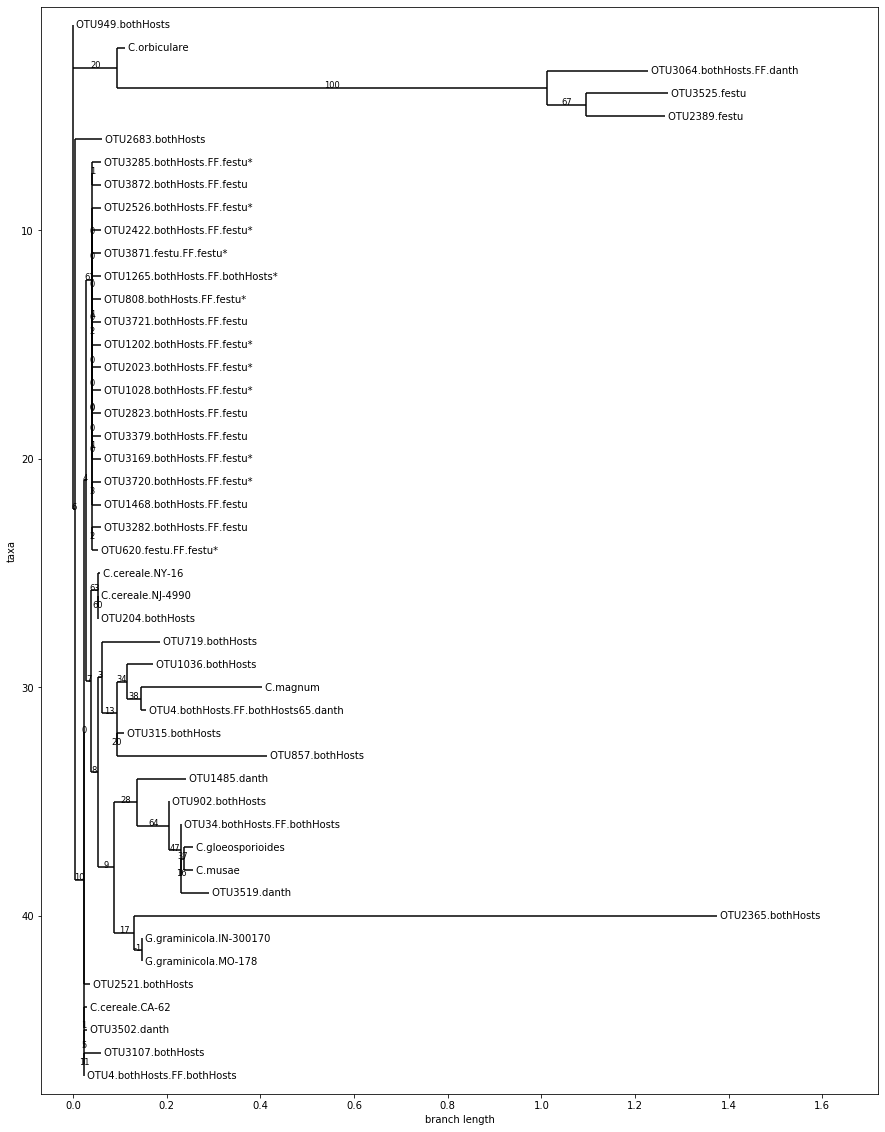

In [43]:
with open('grahamAllSeqsTreeRelabeled.nwk', 'w') as fout:
    fout.write(aa)

## draw it:
fig, ax = plt.subplots(figsize=(15,20))
ITStree = Phylo.read('grahamAllSeqsTreeRelabeled.nwk', 'newick')
Phylo.draw(ITStree, axes=ax)

Asterisks (\*) indicate that the OTU was an indicator species for French Flat. Very wonky branch lengths. Gotta love those ITS trees, branch lengths are not worth anything. 

Anyway, the takeaway is that all the indicator species from french flat lie together in one clade, that is relatively well-supported by this data. Most of the French Flat <i>Colletorichum</i> OTUs are in that clade, even if they are not designated indicator species. Notice that it does seem to be a distinct group from the closest blast matches, the <i>C. graminicola</i> taxa reported by Crouch. 

<a id="ffDiff"></a>
### Are microbiomes of hosts converging at French Flat?

I though that NMSes from Graham's original analysis hinted at some sort of convergence of host microbiomes at French Flat, at least more so than the other sites. So I said two years ago I would check this out. The first step is to reconstruct Graham's NMS graphics. We'll do this with the variance-stabilized biome table made above:

Wisconsin double standardization
Run 0 stress 0.1685803 
Run 1 stress 0.1878271 
Run 2 stress 0.1685803 
... Procrustes: rmse 8.299824e-06  max resid 2.17973e-05 
... Similar to previous best
Run 3 stress 0.180947 
Run 4 stress 0.1685803 
... Procrustes: rmse 1.542307e-05  max resid 3.965681e-05 
... Similar to previous best
Run 5 stress 0.2258885 
Run 6 stress 0.1685803 
... Procrustes: rmse 4.584047e-05  max resid 0.0001064176 
... Similar to previous best
Run 7 stress 0.1862561 
Run 8 stress 0.1852382 
Run 9 stress 0.1856566 
Run 10 stress 0.1907849 
Run 11 stress 0.1685803 
... New best solution
... Procrustes: rmse 5.966488e-06  max resid 1.79349e-05 
... Similar to previous best
Run 12 stress 0.1804967 
Run 13 stress 0.1685803 
... Procrustes: rmse 6.339909e-05  max resid 0.0001386056 
... Similar to previous best
Run 14 stress 0.1685803 
... Procrustes: rmse 5.740435e-06  max resid 1.872362e-05 
... Similar to previous best
Run 15 stress 0.1804967 
Run 16 stress 0.1907849 
Run 1

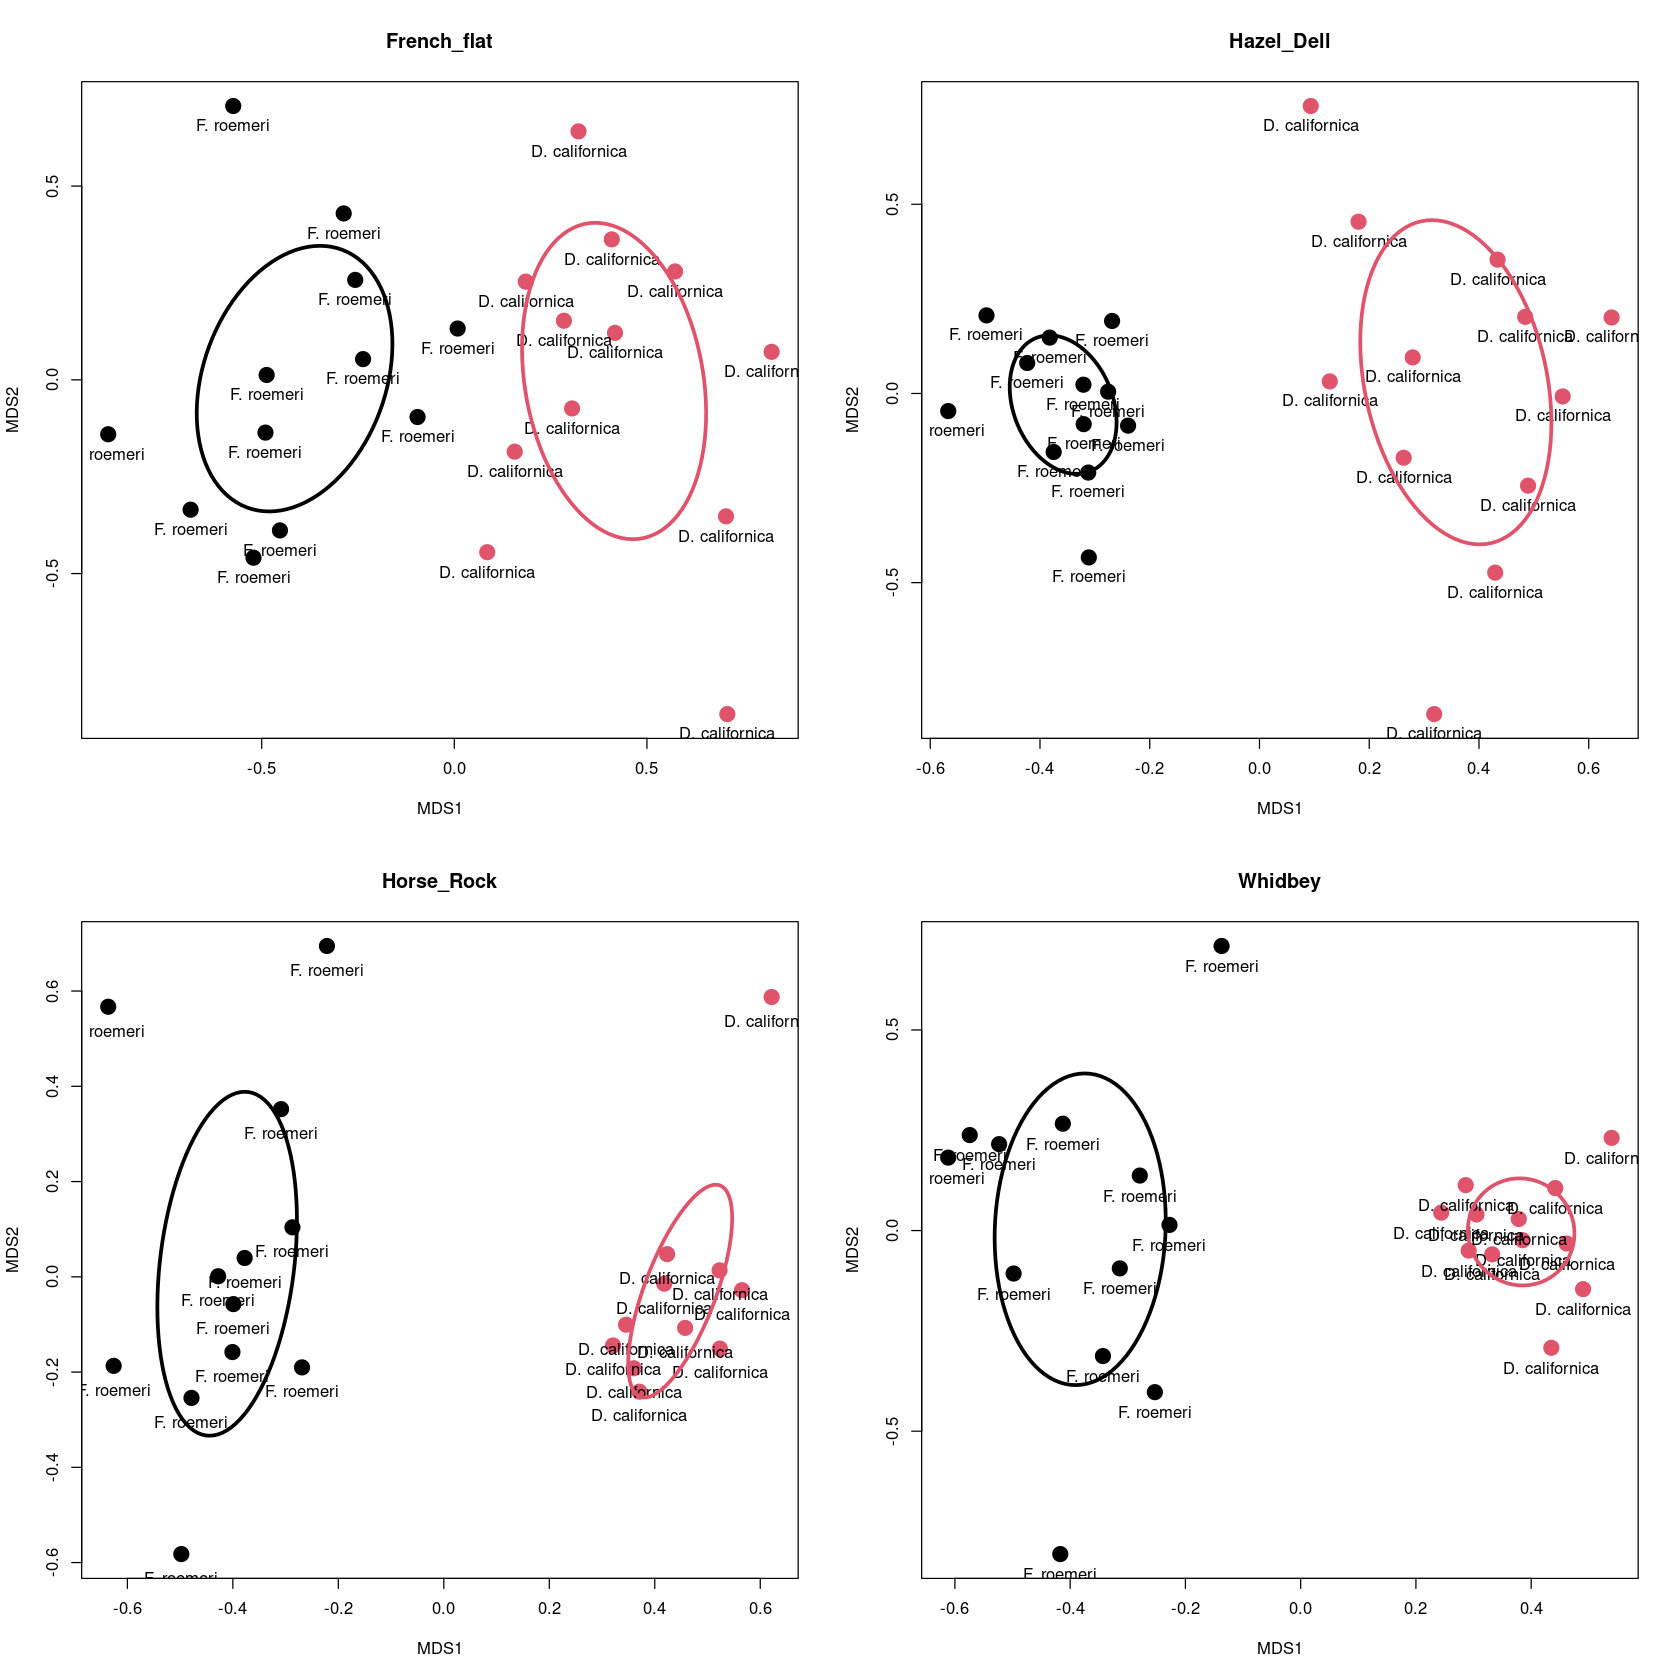

In [8]:
load('biom97vs.rda')
options(repr.plot.width=14, repr.plot.height=14)
par(mfrow=c(2,2))
for (i in c("French_flat","Hazel_Dell","Horse_Rock","Whidbey")){
    sBiom <- subset_samples(biom97vs, site == i)
    sComm <- t(otu_table(sBiom)@.Data)
    sCommNMS = metaMDS(sComm)
    MDS1 <- sCommNMS$points[,'MDS1']
    MDS2 <- sCommNMS$points[,'MDS2']
    host = sample_data(sBiom)[,'host']@.Data[[1]]
    hostNu <- sapply(host, function(x){as.numeric(x == "D. californica")+1})
    plot(MDS1, MDS2,
        col=hostNu,
        pch=19,
        cex=2.0,
        main=i,
    )
    text(MDS1, MDS2-0.05, host)
    ordiellipse(sCommNMS, host, col=c(2,1), lwd=3)
}


Actually, all sites, including French Flat, look pretty cleanly separated. Are the proportion of shared OTUs different?

In [16]:
for (i in c("French_flat","Hazel_Dell","Horse_Rock","Whidbey")){
    sBiom <- subset_samples(biom97vs, site == i)
    DanthBiom <- subset_samples(sBiom, host == "D. californica")
    FestuBiom <- subset_samples(sBiom, host == "F. roemeri")
    DanthBiomNo0 <- otu_table(DanthBiom)[rowSums(otu_table(DanthBiom)) > 0]
    FestuBiomNo0 <- otu_table(FestuBiom)[rowSums(otu_table(FestuBiom)) > 0]
    cat(i)
    cat(paste(" shared OTUs, both hosts: ", 
          sum(rownames(FestuBiomNo0) %in% rownames(DanthBiomNo0)), "\n", sep=''))
    cat("Out of: \n") 
    cat(paste("Danthonia OTU total: ", nrow(DanthBiomNo0), "\n", sep=''))
    cat(paste("Festuca OTU total: ", nrow(FestuBiomNo0), sep=''))
    cat("\n\n")
}


French_flat shared OTUs, both hosts: 404
Out of: 
Danthonia OTU total: 734
Festuca OTU total: 847

Hazel_Dell shared OTUs, both hosts: 356
Out of: 
Danthonia OTU total: 891
Festuca OTU total: 710

Horse_Rock shared OTUs, both hosts: 375
Out of: 
Danthonia OTU total: 955
Festuca OTU total: 902

Whidbey shared OTUs, both hosts: 396
Out of: 
Danthonia OTU total: 709
Festuca OTU total: 999



Another way to look at this is with Bray-Curtis between the two grass hosts at each site:

In [14]:
for (i in c("French_flat","Hazel_Dell","Horse_Rock","Whidbey")){
    sBiom <- subset_samples(biom97vs, site == i)
    sDanthBiom <- subset_samples(sBiom, host == "D. californica")
    sFestuBiom <- subset_samples(sBiom, host == "F. roemeri")
    aa <- rbind(rowSums(otu_table(sDanthBiom)), rowSums(otu_table(sFestuBiom)))
    cat(paste("BC distance",i,"=", vegdist(aa, method='bray')[1], "\n", sep=' '))
}

BC distance French_flat = 0.516395026163512 
BC distance Hazel_Dell = 0.522760777282896 
BC distance Horse_Rock = 0.556418835076446 
BC distance Whidbey = 0.505372964053005 


Both the % shared species and BC distance are about them same at all sites. So, with the pipeline here used, I'm really not seeing a difference here, the two species of grass seem as separated/convergent in their microbiomes as the other sites. 